In [1]:
from sklearn.datasets import load_files
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
import numpy as np
from glob import glob
import random
import cv2
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True 
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg19 import VGG19
#from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.mobilenet import MobileNet
import matplotlib.pyplot as plt     
from keras.preprocessing import image                  
from tqdm import tqdm
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D,GlobalMaxPooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.models import model_from_json
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import log_loss
from keras import optimizers
import math
import pickle
import os
import pandas as pd
import datetime
from keras.models import Model
def model_history(history):

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def save_model(model):
    json_string = model.to_json()
    if not os.path.isdir('cache'):
        os.mkdir('cache')
    open(os.path.join('cache', 'model_vgg16.json'), 'w').write(json_string)


def read_model():
    model = model_from_json(open(os.path.join('cache', 'model_vgg16.json')).read())
    return model

def create_submission(predictions, test_id, loss):
    print('Started building csv file')
    result1 = pd.DataFrame(predictions, columns=['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
    result1.insert(loc=0, column='img', value=test_id)
    now = datetime.datetime.now()
    if not os.path.isdir('subm'):
        os.mkdir('subm')
    suffix = str(round(loss, 6)) + '_' + str(now.strftime("%Y-%m-%d-%H-%M"))
    sub_file = os.path.join('subm', 'submission_' + suffix + '.csv')
    result1.to_csv(sub_file, index=False)
    print("successfully created submission")   
    
def cache_data(data, path):
    if os.path.isdir(os.path.dirname(path)):
        file = open(path, 'wb')
        pickle.dump(data, file)
        file.close()

def restore_data(path):
    data = dict()
    if os.path.isfile(path):
        file = open(path, 'rb')
        data = pickle.load(file)
    return data

def read_imc(path):
    # Load as grayscale
    #img = cv2.imread(path, 0)
    # Reduce size
    #resized = cv2.resize(img, (224, 224))
    #x = image.img_to_array(path)
    #resized=np.expand_dims(x, axis=0)
    img = cv2.imread(path)
    img_rows, img_cols=224,224
   # resized = cv2.resize(img, (96, 128), cv2.INTER_LINEAR)
    resized = cv2.resize(img, (img_rows, img_cols))
    return resized

def get_driver_data():
    dr = dict()
    clss = dict()
    path ='Data/driver_imgs_list.csv'
    print('Read drivers data')
    f = open(path, 'r')
    line = f.readline()
    while (1):
        line = f.readline()
        if line == '':
            break
        arr = line.strip().split(',')
        dr[arr[2]] = arr[0]
        if arr[0] not in clss.keys():
            clss[arr[0]] = [(arr[1], arr[2])]
        else:
            clss[arr[0]].append((arr[1], arr[2]))
    f.close()
    return dr, clss

def load_train():
    #path='Data/imgs/train'
    #data=load_files(path)
    #driver_file=np.array(data['filenames'])
    #driver_target=np_utils.to_categorical(np.array(data['target']),10)
    #data=glob(path)
    driver_file=[]
    driver_target=[]
    driver_id=[]
    driver_file_id=[]
    driver_data, dr_class = get_driver_data()
    print('driver data and class sample',len(driver_data),len(dr_class))
    for j in range(10):
        print('Load folder c{}'.format(j))
        path = os.path.join( 'Data', 'imgs', 'train', 'c' + str(j), '*.jpg')
        data = glob(path)
        for p in data:
            
            driver_file.append(read_imc(p))
            driver_target.append(j)
            base = os.path.basename(p)
            driver_file_id.append(base)
            driver_id.append(driver_data[base])
            #print(driver_data[base])
    unique_drivers = sorted(list(set(driver_id)))
    print('Unique drivers: {}'.format(len(unique_drivers)))
    print(unique_drivers)
    return driver_file,driver_target,driver_file_id,driver_id,unique_drivers

def load_test():
    path='Data/imgs/test/*'
    data=glob(path)
    driver_file=[]
    driver_id=[]  
    for p in data:
        driver_file.append(read_imc(p))
        driver_id.append(os.path.basename(p))
        
   # driver_id=os.path.basename(p)
    #test_id=np.array(driver_file['target'])
    return driver_file,driver_id

def split_list_trial(l,size):
    return [l[i:i + size] for i in range(0, len(l), size)]

def split_list(l,size):
    return [l[i*len(l) // size: (i+1)*len(l) // size] for i in range(size)]

def load_test_parts(part,splits):
    path='Data/imgs/test/*'
    data=glob(path)
    driver_file=[]
    driver_id=[]  
    test_chunks=split_list(data,splits)
    
    for p in test_chunks[part]:
        driver_file.append(read_imc(p))
        driver_id.append(os.path.basename(p))
        
    #del data
    #del test_chunks
   # driver_id=os.path.basename(p)
    #test_id=np.array(driver_file['target'])
    return driver_file,driver_id

def append_chunk(main, part):
    for p in part:
        main.append(p)
        
    return main
def print_sample(data,target):
    print ("X shape",data.shape) 
    print ("Y shape",target.shape)
    
   # for p in data[:2]: print (p)
  #  for p in target[:2]: print (p)
    #im = cv2.imread(data[1])
    # show sample image   
    #plt.imshow(im)
    #plt.show()
    return None

def get_selected_drivers(train_data, train_target, driver_id, driver_list):
    data = []
    target = []
   
    for i in range(len(train_data)):
        if driver_id[i] in driver_list:
            data.append(train_data[i])
            target.append(train_target[i])
            
    data = np.array(data)
    target = np.array(target)
    print('driver list length',len(driver_list))
    return data, target


def data_split(data,target,test_size,driver_id,driver_list):
 #   if unique==True:
        
       # perm = np.random.permutation(len(target))
        #x,y = data[perm], target[perm]
        #unique_list_train = [unique_drivers[i] for i in train_drivers]
        
        #drivers_list=drivers_list[perm]
        random.shuffle(driver_list)
        #test_size=0.2
        test_split=test_size*len(driver_list)
        test_split=int(round(test_split))
       
        train_list=driver_list[test_split:]
        test_list=driver_list[:test_split]
        
        X_train,y_train = get_selected_drivers(data,target,driver_id,train_list)
        X_test,y_test = get_selected_drivers(data,target,driver_id,test_list)
        
       # perm = np.random.permutation(len(y_train))
       # X_train,y_train = X_train[perm], y_train[perm]
        
       # perm = np.random.permutation(len(y_test))
       # X_test,y_test = X_test[perm], y_test[perm]
        
       # print('Train shape',train_list )
       # print('Test shape',test_list)

  #  else:    
   #     X_train, X_split, y_train, y_split = train_test_split(data,target,test_size=test_size,random_state=42)
    
        return X_train, X_test, y_train, y_test, test_list
    
img_rows=224
img_cols=224
img_channel=3  

batch_size=32

Using TensorFlow backend.


# SECTION USED ONLY TO SPLIT DATA

cache_path= os.path.join('cache','train_224.dat')
if not os.path.isfile(cache_path):
    print('building train cache')
    train_files,train_targets,train_id, driver_id, unique_drivers = load_train()
    cache_data((train_files,train_targets,train_id, driver_id, unique_drivers),cache_path)
    print('train cache built')           
else:
    print('Restore train from cache')
    (train_files,train_targets,train_id, driver_id, unique_drivers)=restore_data(cache_path)

train_files=np.array(train_files,dtype=np.uint8)

train_files = train_files.reshape(train_files.shape[0], img_rows, img_cols,img_channel)


test_size=0.3
X_train, X_split, y_train, y_split,split_driver_list =data_split(train_files,train_targets,test_size,driver_id,unique_drivers)

del train_files
del train_targets

test_size=0.4
X_test, X_val, y_test, y_val,val_driver_list = data_split(X_split,y_split,test_size,driver_id,split_driver_list)

cache_path= os.path.join('cache','train_split_224.dat')
if not os.path.isfile(cache_path):
    print('building train cache')
    cache_data((X_train,y_train),cache_path)
    print('train cache built')           

    
cache_path= os.path.join('cache','val_split_224.dat')
if not os.path.isfile(cache_path):
    print('building val cache')
    cache_data((X_val,y_val),cache_path)
    print('val cache built')           

    
cache_path= os.path.join('cache','test_split_224.dat')
if not os.path.isfile(cache_path):
    print('building test cache')
    cache_data((X_test,y_test),cache_path)
    print('test cache built')           
    


Restore train split from cache
Restore val split from cache
Epoch 00000: val_loss improved from inf to 1.06451, saving model to saved_models/weightsfromscratch.hdf5
Epoch 00001: val_loss improved from 1.06451 to 0.88049, saving model to saved_models/weightsfromscratch.hdf5
Epoch 00002: val_loss improved from 0.88049 to 0.80709, saving model to saved_models/weightsfromscratch.hdf5
Epoch 00003: val_loss improved from 0.80709 to 0.76898, saving model to saved_models/weightsfromscratch.hdf5
Epoch 00004: val_loss improved from 0.76898 to 0.75874, saving model to saved_models/weightsfromscratch.hdf5


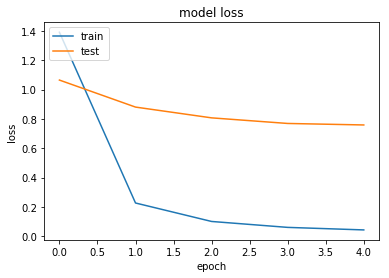

Restore test split from cache
Score log_loss:  0.678410649227


In [2]:
cache_path= os.path.join('cache','train_split_224.dat')   
if os.path.isfile(cache_path):
    print('Restore train split from cache')
    (X_train,y_train)=restore_data(cache_path)
else:
    print('train split data cache is empty')
    
X_train=np.array(X_train,dtype=np.uint8)
y_train=np.array(y_train,dtype=np.uint8)
y_train=np_utils.to_categorical(y_train,10)

#train_files = train_files.reshape(train_files.shape[0], img_rows, img_cols,img_channel)
    
    
cache_path= os.path.join('cache','val_split_224.dat')   
if os.path.isfile(cache_path):
    print('Restore val split from cache')
    (X_val,y_val)=restore_data(cache_path)
else:
    print('val split data cache is empty')
    
X_val=np.array(X_val,dtype=np.uint8)
y_val=np.array(y_val,dtype=np.uint8)
y_val=np_utils.to_categorical(y_val,10)   


train_datagen=ImageDataGenerator(
   rescale=1./255,
   #shear_range=0.2,
   zoom_range=0.2,
   width_shift_range=0.1,
   height_shift_range=0.1, 
   horizontal_flip=False
    
    )

val_datagen=ImageDataGenerator(
   rescale=1./255, 
   zoom_range=0.1,
   width_shift_range=0.1,
   height_shift_range=0.1, 
   horizontal_flip=False
    )


### TODO: Define your architecture.

from keras.layers import Input

input_tensor = Input(shape=(224, 224, 3))
base_model = InceptionV3(input_shape=(224,224,3),weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
#x = GlobalMaxPooling2D()(x)
# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)
#x =Dropout(0.4)(x)
#x = Dense(512, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


model.compile(optimizer=SGD(lr=0.0009, momentum=0.7), loss='categorical_crossentropy')
#model.compile(optimizer=SGD(lr=0.0009, momentum=0.9), loss='categorical_crossentropy')
#model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')
#model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

train_datagen.fit(X_train)
val_datagen.fit(X_val)

checkpointer = ModelCheckpoint(filepath='saved_models/weightsfromscratch.hdf5', 
                               verbose=1, save_best_only=True)
epochs=5

history=model.fit_generator(train_datagen.flow(X_train,y_train,batch_size=batch_size),
                            validation_data=val_datagen.flow(X_val,y_val),
                    steps_per_epoch=len(X_train)//batch_size,validation_steps=len(X_val)//batch_size,epochs=epochs,
                            callbacks=[checkpointer],verbose=0)
save_model(model)
model_history(history)


#model.load_weights('saved_models/weightsfromscratch.hdf5')
#score = model.evaluate(X_test, y_test, verbose=1)
#print(score)

cache_path= os.path.join('cache','test_split_224.dat')    
if os.path.isfile(cache_path):
    print('Restore test split from cache')
    (X_test,y_test)=restore_data(cache_path)
else:
    print('Test split data cache is empty')
X_test=np.array(X_test,dtype=np.uint8)
y_test=np.array(y_test,dtype=np.uint8)
y_test=np_utils.to_categorical(y_test,10)   

X_test = X_test.astype('float32')
X_test/=255
predictions=model.predict(X_test, verbose=0)
score=log_loss(y_test,predictions)
print('Score log_loss: ', score)
      

global average pooling Xception Score log_loss:  2.2960430687
global max pooling Xception Score log_loss:  2.29670835679
global average pooling resnet Score log_loss:  5.34713518405
Global average pooling vgg19 Score log_loss:  31.0368328663
Global average pooling inceptionv3 Score log_loss:  1.95701219222
Global max pooling inceptionv3 Score log_loss:  30.0924949305
Global average pooling vgg16 Score log_loss:  30.9338345272
Global max pooling vgg16 Score log_loss:  30.6248395097
Global average pooling mobilenet Score log_loss:  2.47601450317
Dense 512 Inceptionv3 Score log_loss:  1.37379334373

In [2]:
model = read_model()
model.load_weights('saved_models/weightsfromscratch.hdf5')
    #model.compile(loss='categorical_crossentropy', optimizer='adadelta')
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
print('read and compiled model')
    

read and compiled model


In [3]:


predictions=[]
test_ids=[]
test_splits=5
for x in range(test_splits):
    print('iteration: ',x)
   # cache_path=None
    y=x+1
    cache_path= os.path.join('cache','test_224_part'+str(y)+'.dat')

    if not os.path.isfile(cache_path):
        print('building test cache')
        test_files,test_id = load_test_parts(x,test_splits)
        cache_data((test_files,test_id),cache_path)
        print('test cache built')
    else:
        print('Restore test from cache')
        (test_files,test_id)=restore_data(cache_path)
    
    test_files=np.array(test_files,dtype=np.uint8)    
    test_files = test_files.reshape(test_files.shape[0], img_rows, img_cols,img_channel)
    test_files = test_files.astype('float32')
  
    print('test length',test_files.shape)
    test_files/=255
    
    prediction=model.predict(test_files,  batch_size=batch_size)
    predictions=append_chunk(predictions,prediction)
    test_ids=append_chunk(test_ids,test_id)
    del test_files
    print('prediction length ',len(predictions))
   # np.stack(test_ids,test_id)
    print('test id length ',len(test_ids))
score=2.022
print('prediction length ',len(predictions))
create_submission(predictions,test_ids,score)    

iteration:  0
Restore test from cache
test length (15945, 224, 224, 3)
prediction length  15945
test id length  15945
iteration:  1
Restore test from cache
test length (15945, 224, 224, 3)
prediction length  31890
test id length  31890
iteration:  2
Restore test from cache
test length (15945, 224, 224, 3)
prediction length  47835
test id length  47835
iteration:  3
Restore test from cache
test length (15945, 224, 224, 3)
prediction length  63780
test id length  63780
iteration:  4
Restore test from cache
test length (15946, 224, 224, 3)
prediction length  79726
test id length  79726
prediction length  79726
Started building csv file
successfully created submission
